In this file, we check correlation between survey values for each party and article number for the wars with most media presens. 
To check whether the correlation is statistically significant, we do a permutation test for each correlation value and obtain a p-value.

In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math

read_path =  r'C:\Users\Julia\Documents\Uni\Master\1\Data-Literacy\Data-Literacy\Data\joined_survey_article_standardized_median.csv'
df = pd.read_csv(read_path, delimiter=';', header=0)
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
df["SPD"] = pd.to_numeric(df["SPD"], errors='coerce')
df["Union"] = pd.to_numeric(df["Union"], errors='coerce')
df["Grüne"] = pd.to_numeric(df["Grüne"], errors='coerce')
df["FDP"] = pd.to_numeric(df["FDP"], errors='coerce')
df["AfD"] = pd.to_numeric(df["AfD"], errors='coerce')
df["Linke"] = pd.to_numeric(df["Linke"], errors='coerce')

First we define the timeframes to test. In our opinion it does not make sense to calculate correlation for all years: due to different opinions on each war a party might have positive or negative correlations for different wars.
The wars with the most media presens are defined by the highest article numbers:
**2003: january, february, march, april -> Irakkrieg**
2008: August -> Russland und Georgien
2009: januray -> Operation Gegossenes Blei, Israel und der Hamas im Gazastreifen.
**2022 and 2023: all year -> verschiedene Konflikte, Russland und Ukraine**
We decide not to calculate correlation for 2008 and 2009, as both wars are media present only for one to two surveys. For war in Irak and Ukraine we look at the correlation of each parties values with the article number. For Irak war we add half a year before and after media presence. For Ukraine war we start at the first media presenz and calcuate correlation until our last values, as the conflict is ongoing.

In [2]:
this_df = df[(df['date'].dt.year >= 2002) & (df['date'].dt.year <= 2004)]
high_values = this_df[this_df['standardized_war_articles'] >= 0.2]
first = high_values['date'].iloc[-1]
last = high_values['date'].iloc[0]
new_first = first - datetime.timedelta(days=6*30)
new_last = last + datetime.timedelta(days=6*30)
war_df_irak = df[(df['date'] >= new_first) & (df['date'] <= new_last)]

In [3]:
correlation_matrix_irak = war_df_irak.corr()
correlation_matrix_irak['standardized_war_articles']

C:\Users\Julia\AppData\Local\Temp\ipykernel_1196\3864863046.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_irak = war_df_irak.corr()


Unnamed: 0                   0.004723
SPD                         -0.293295
Union                        0.368109
Grüne                        0.388835
FDP                         -0.373680
AfD                               NaN
Linke                       -0.551424
standardized_war_articles    1.000000
Name: standardized_war_articles, dtype: float64

In [4]:
this_df = df[(df['date'].dt.year >= 2022) & (df['date'].dt.year <= 2023)]
high_values = this_df[this_df['standardized_war_articles'] >= 0.2]
first = high_values['date'].iloc[-1]
new_first = first - datetime.timedelta(days=6*30)
war_df_ukraine = df[(df['date'] >= new_first)]

In [5]:
correlation_matrix_ukraine = war_df_ukraine.corr()
correlation_matrix_ukraine['standardized_war_articles']

C:\Users\Julia\AppData\Local\Temp\ipykernel_1196\3685756595.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_ukraine = war_df_ukraine.corr()


Unnamed: 0                  -0.172543
SPD                         -0.131870
Union                        0.359961
Grüne                        0.129753
FDP                         -0.393386
AfD                          0.039217
Linke                       -0.365879
standardized_war_articles    1.000000
Name: standardized_war_articles, dtype: float64

In [6]:
df_res = pd.DataFrame({"Iraq": correlation_matrix_irak['standardized_war_articles'],
                       "Ukraine": correlation_matrix_ukraine['standardized_war_articles']})
df_res = df_res.drop(["Unnamed: 0", "standardized_war_articles"])
df_res = df_res.sort_values(by='Iraq')
df_res

,Iraq,Ukraine
Linke,-0.551424,-0.365879
FDP,-0.373680,-0.393386
SPD,-0.293295,-0.131870
Union,0.368109,0.359961
Grüne,0.388835,0.129753
AfD,NaN,0.039217


It seems like there are similar correlations for each party for both wars. To check whether the correlation is statistically significant, we do a permutation test for each correlation value and obtain a p-value. For that we permute the article values for the investigated timeframe.

In [7]:
def permutation_test(df_test, corr_matrix, party):
    B = 10000
    corr_values = []
    extrem_values = 0
    for x in range(B):
        df_permuted = df_test.copy()
        # permute exising values
        df_permuted["standardized_war_articles"] = np.random.permutation(df_permuted["standardized_war_articles"])
        corr_permuted = df_permuted.corr()["standardized_war_articles"][party]
        corr_values.append(corr_permuted)
        true_value = corr_matrix["standardized_war_articles"][party]
        if abs(corr_permuted) > abs(true_value):
            extrem_values += 1

    p_value = extrem_values / B        
    #fig, axs = plt.subplots()
    #axs.hist(corr_values)
    #axs.axvline(corr_matrix["standardized_war_articles"][party], alpha=1.0, color="red")
    return p_value

In [8]:
p_values_irak = [permutation_test(war_df_irak, correlation_matrix_irak, "SPD"),
                 permutation_test(war_df_irak, correlation_matrix_irak, "Union"),
                 permutation_test(war_df_irak, correlation_matrix_irak, "Grüne"),
                 permutation_test(war_df_irak, correlation_matrix_irak, "FDP"),
                 float('nan'),
                 permutation_test(war_df_irak, correlation_matrix_irak, "Linke")]

p_values_ukraine = [permutation_test(war_df_ukraine, correlation_matrix_ukraine, "SPD"),
                    permutation_test(war_df_ukraine, correlation_matrix_ukraine, "Union"),
                    permutation_test(war_df_ukraine, correlation_matrix_ukraine, "Grüne"),
                    permutation_test(war_df_ukraine, correlation_matrix_ukraine, "FDP"),
                    permutation_test(war_df_ukraine, correlation_matrix_ukraine, "AfD"),
                    permutation_test(war_df_ukraine, correlation_matrix_ukraine, "Linke")]

df_pvalues = pd.DataFrame({"Iraq": p_values_irak, "Ukraine": p_values_ukraine}, index=["SPD", "Union", "Grüne", "FDP", "AfD", "Linke"])
df_pvalues

C:\Users\Julia\AppData\Local\Temp\ipykernel_1196\397864076.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_permuted = df_permuted.corr()["standardized_war_articles"][party]


,Iraq,Ukraine
SPD,0.0186,0.3473
Union,0.0033,0.0077
Grüne,0.0019,0.3493
FDP,0.0028,0.0032
AfD,NaN,0.7719
Linke,0.0000,0.0057


In [9]:
res_significant = pd.DataFrame(index=["SPD", "Union", "Grüne", "FDP", "AfD", "Linke"], columns=["Iraq", "Ukraine"])
for i in ["Iraq", "Ukraine"]:
    for j in ["SPD", "Union", "Grüne", "FDP", "AfD", "Linke"]:
        if math.isnan(df_pvalues[i][j]):
            continue
        if df_pvalues[i][j] <= 0.05:
            res_significant[i][j] = str(round(df_res[i][j], 2)) + "*"
        else:
            res_significant[i][j] = str(round(df_res[i][j], 2))
res_significant

#with open('mytable.tex','w') as tf:
#    tf.write(res_significant.to_latex())

,Iraq,Ukraine
SPD,-0.29*,-0.13
Union,0.37*,0.36*
Grüne,0.39*,0.13
FDP,-0.37*,-0.39*
AfD,NaN,0.04
Linke,-0.55*,-0.37*


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


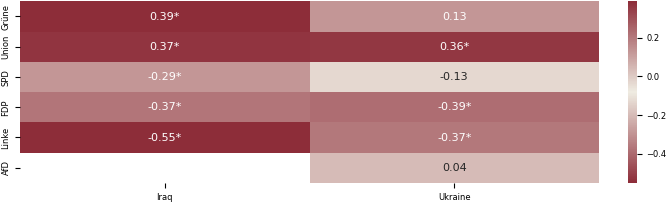

In [30]:
# heatmap with correlation values
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

from tueplots import bundles
from tueplots.constants.color.palettes import rgb

plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=2, usetex=False))

df_res_sorted = df_res.sort_values(by = 'Iraq', ascending=False)
labels = res_significant.sort_values(by='Iraq', key=lambda col: col.str[0:-1].astype(float), ascending=False).values

cmap = LinearSegmentedColormap.from_list('', [rgb.tue_red, rgb.tue_lightgold, rgb.tue_red])
axis_labels = df_res_sorted.index.values


sns.heatmap(df_res_sorted, yticklabels=axis_labels, cmap = cmap, annot=labels, fmt="" )

plt.show()

In [29]:
df_res_sorted

,Iraq,Ukraine
Linke,-0.551424,-0.365879
FDP,-0.373680,-0.393386
SPD,-0.293295,-0.131870
Union,0.368109,0.359961
Grüne,0.388835,0.129753
AfD,NaN,0.039217


In [16]:
labels = res_significant.sort_values(by='Iraq', key=lambda col: col.str[0:-1].astype(float), ascending=False).values
labels

array([['0.39*', '0.13'],
       ['0.37*', '0.36*'],
       ['-0.29*', '-0.13'],
       ['-0.37*', '-0.39*'],
       ['-0.55*', '-0.37*'],
       [nan, '0.04']], dtype=object)

In [12]:
labels = res_significant.values
labels

array([['-0.29*', '-0.13'],
       ['0.37*', '0.36*'],
       ['0.39*', '0.13'],
       ['-0.37*', '-0.39*'],
       [nan, '0.04'],
       ['-0.55*', '-0.37*']], dtype=object)

In [13]:
res_significant.sort_values(by='Iraq', key=lambda col: col.str[0:-1].astype(float), ascending=False)

,Iraq,Ukraine
Grüne,0.39*,0.13
Union,0.37*,0.36*
SPD,-0.29*,-0.13
FDP,-0.37*,-0.39*
Linke,-0.55*,-0.37*
AfD,NaN,0.04


['Grüne', 'Union', 'Linke', 'FDP', 'SPD', 'AfD']